In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# EDA


In [21]:
import pandas as pd
import numpy as np

dataset = pd.read_csv("/content/drive/MyDrive/datasets/News.csv")

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
dataset.head()

,Unnamed: 0,title,text,subject,date,class
0,0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [24]:
dataset.nunique()

,0
Unnamed: 0,23502
title,38740
text,38657
subject,19
date,2408
class,2


In [25]:
dataset =  dataset.drop(["title", "subject","date","Unnamed: 0"], axis = 1)

In [26]:
dataset.isnull().sum()

,0
text,0
class,0


In [27]:
dataset.columns.tolist()

['text', 'class']

In [28]:
dataset.describe()

,class
count,44919.000000
mean,0.476792
std,0.499467
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [29]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44919 entries, 0 to 44918
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    44919 non-null  object
 1   class   44919 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 702.0+ KB


In [30]:
dataset = dataset.sample(frac=1)
dataset.reset_index(inplace=True)
dataset.drop(["index"], axis=1, inplace=True)

<Axes: xlabel='class', ylabel='count'>

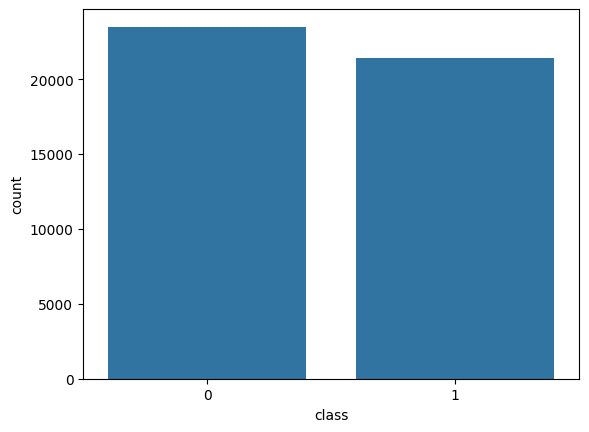

In [32]:
sns.countplot(data=dataset,x='class',order=dataset['class'].value_counts().index)

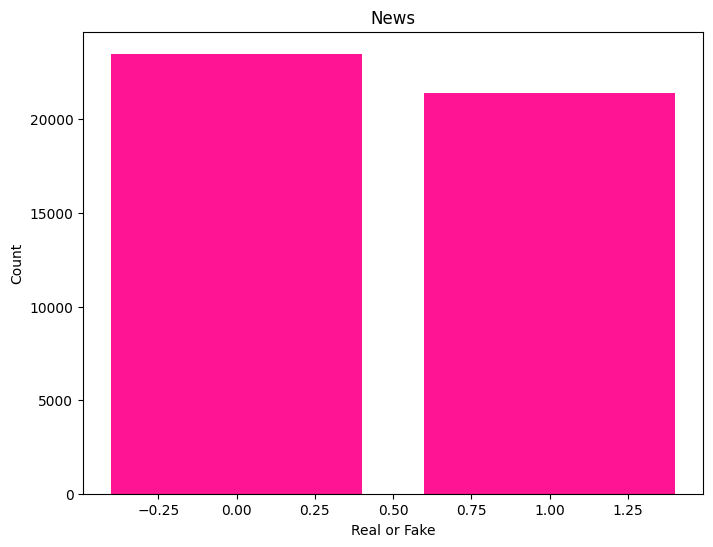

In [33]:
class_counts = dataset['class'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(class_counts.index, class_counts, color='deeppink')
plt.title('News')
plt.xlabel('Real or Fake')
plt.ylabel('Count')
plt.show()

# Preprocessing


In [36]:
from tqdm import tqdm
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [40]:
def preprocess_text(text_data):
    preprocessed_text = []

    for sentence in tqdm(text_data):
        sentence = re.sub(r'[^\w\s]', '', sentence)
        preprocessed_text.append(' '.join(token.lower()
                                  for token in str(sentence).split()
                                  if token not in stopwords.words('english')))

    return preprocessed_text

In [41]:

preprocessed_review = preprocess_text(dataset['text'].values)
dataset['text'] = preprocessed_review

100%|██████████| 44919/44919 [29:29<00:00, 25.38it/s]


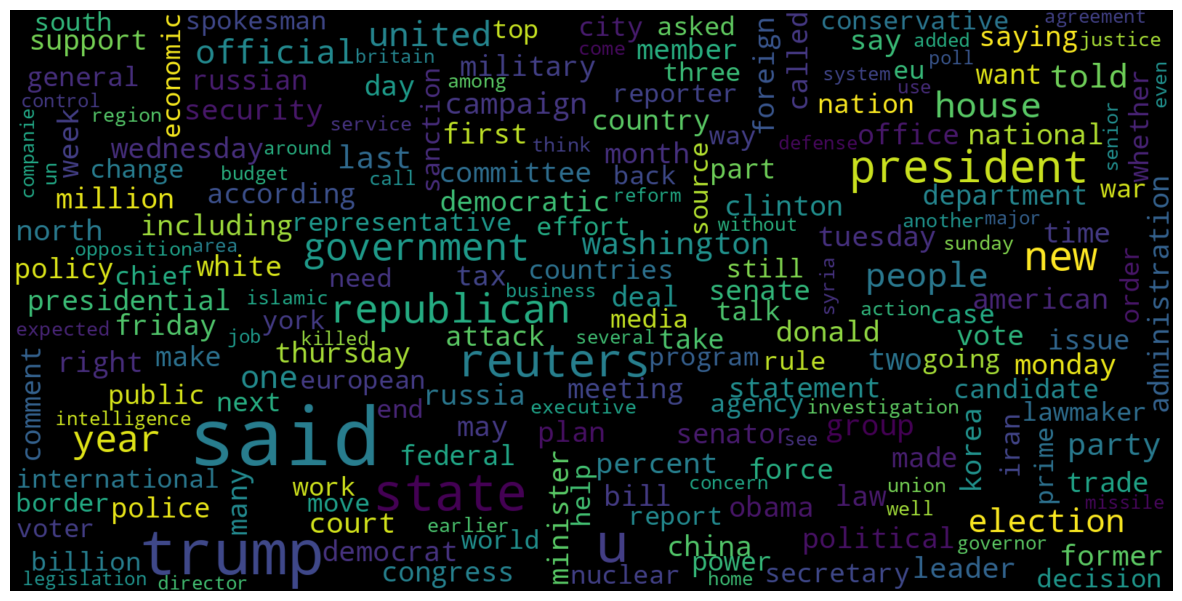

In [42]:
consolidated = ' '.join(word for word in dataset['text'][dataset['class'] == 1].astype(str))

wordCloud = WordCloud(width=1600,
                      height=800,
                      random_state=21,
                      max_font_size=110,
                      collocations=False)

plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()

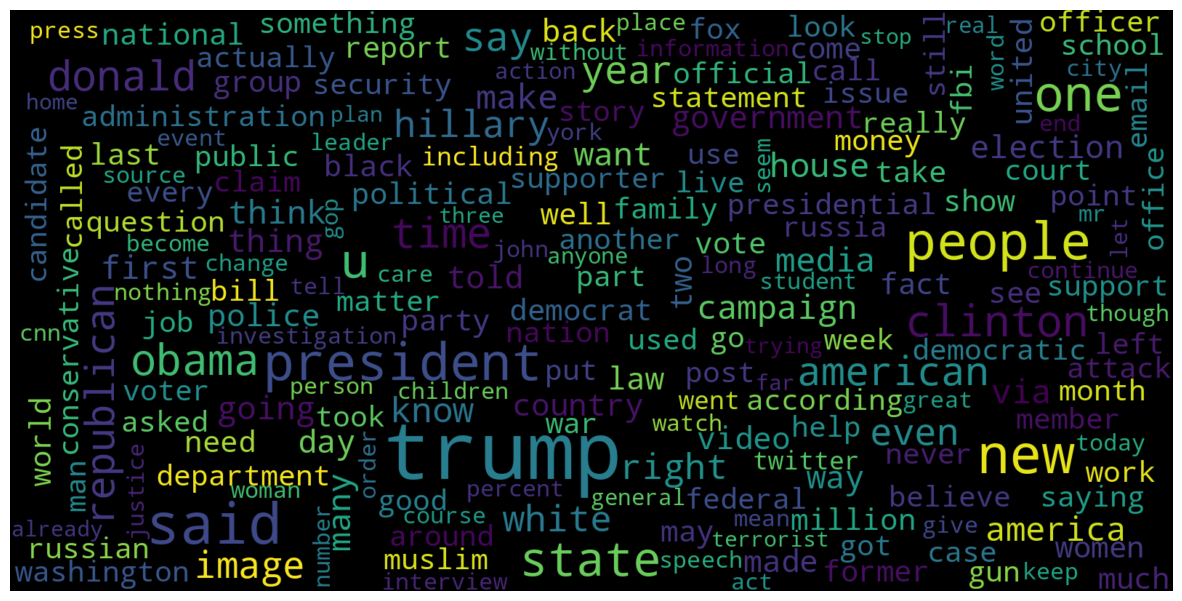

In [43]:
consolidated = ' '.join(word for word in dataset['text'][dataset['class'] == 0].astype(str))

wordCloud = WordCloud(width=1600,
                      height=800,
                      random_state=21,
                      max_font_size=110,
                      collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()

<Axes: title={'center': 'Bar Chart of Top Words Frequency'}, xlabel='Top Words', ylabel='Count'>

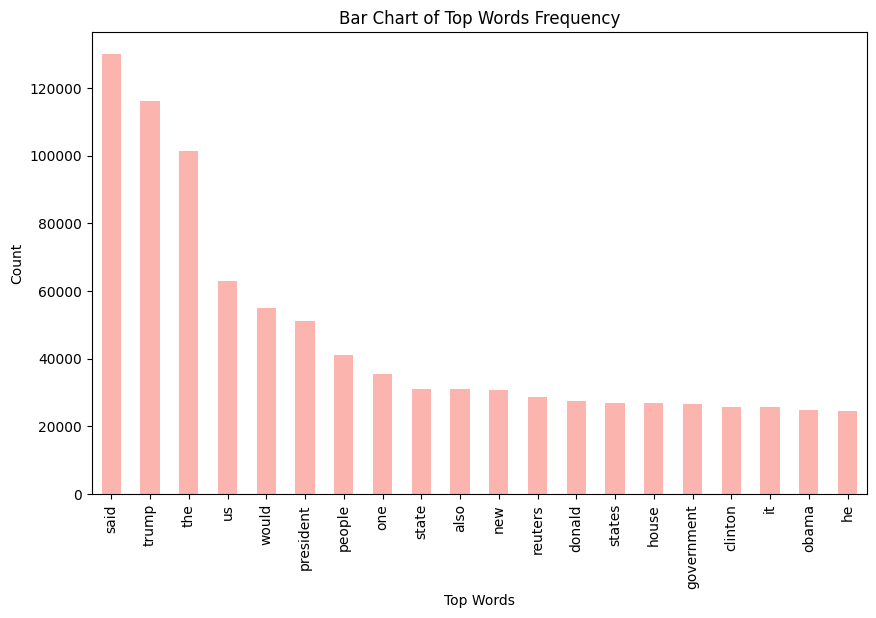

In [44]:
from sklearn.feature_extraction.text import CountVectorizer


def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1],reverse=True)
    return words_freq[:n]


common_words = get_top_n_words(dataset['text'], 20)
df1 = pd.DataFrame(common_words, columns=['Review', 'count'])

df1.groupby('Review').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',
    figsize=(10, 6),
    xlabel="Top Words",
    ylabel="Count",
    title="Bar Chart of Top Words Frequency"
)

# Training


In [45]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

x_train, x_test, y_train, y_test = train_test_split(dataset['text'],dataset['class'],test_size=0.25)

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorization = TfidfVectorizer()
x_train = vectorization.fit_transform(x_train)
x_test = vectorization.transform(x_test)

In [47]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(x_train, y_train)


print(f"Train Accuracy:{accuracy_score(y_train, model.predict(x_train))}")
print(f"Test Accuracy:{accuracy_score(y_test, model.predict(x_test))}")

Train Accuracy:0.9936180949271276
Test Accuracy:0.9895814781834372


In [48]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(x_train, y_train)

print(f"Train Accuracy:{accuracy_score(y_train, model.predict(x_train))}")
print(f"Test Accuracy:{accuracy_score(y_test, model.predict(x_test))}")

Train Accuracy:0.9999703167205913
Test Accuracy:0.9965271593944791


## Confusion Matrix of Decision Tree Classifier

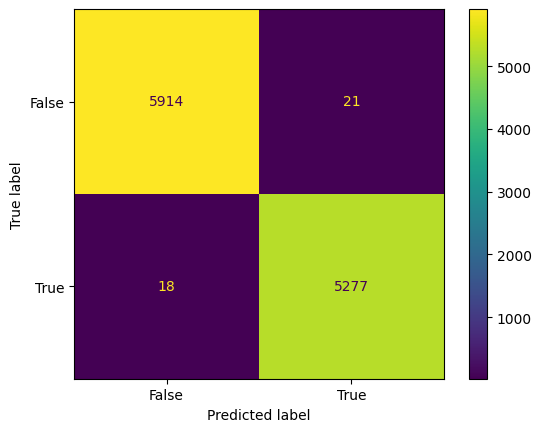

In [49]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, model.predict(x_test))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[False, True])

cm_display.plot()
plt.show()

# Extra
You could try training with random forest or xgbooost to try different models or even ensemble techniques but logistic regression and decision tree works completely fine!